## Connect with Google Drive

In [0]:
from google.colab import drive 
drive.mount("/betogaona7")

In [2]:
%cd ./../betogaona7/My Drive/app/Recognition

/betogaona7/My Drive/app/Recognition


In [1]:
%pwd

'/content'

## Imports 

In [0]:
import os
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from torch.utils.data import Dataset
import torchvision.transforms as transforms


import torch.nn as nn
import torch.nn.functional as F
from torch import optim

## Build dataset

In [120]:
def imgs_with_id(src):
  data = []
  imgs = 0
  for path, subdir, files in os.walk(src):
    for file in files:
      if int(path[-2:]) < 38: # and path[10:16] != "_S4_C2":
        if file[-3:] == "pgm":
          data.append((os.path.join(path, file), path[-2:]))
          imgs += 1
  return data, imgs 

#data, total = imgs_with_id("datacp/")
data, total = imgs_with_id("./data")
print("Example: img ", data[0][0], " subject id ", data[0][1], " total imgs ", total)

Example: img  ./data/s10/7.pgm  subject id  10  total imgs  370


In [0]:
class ChokePoint(Dataset):
  def __init__(self, data, transform=None):
    self.data = data
    self.transform = transform
  
  def __getitem__(self, index):
    record1 = random.choice(self.data)
    same_class = random.randint(0,1)
    if same_class:
      while True:
        record2 = random.choice(self.data)
        if record1[1] == record2[1]:
          label = 1
          break
    else:
      while True:
        record2 = random.choice(self.data)
        if record1[1] != record2[1]:
          label = 0
          break
    
    img1 = Image.open(record1[0])
    img2 = Image.open(record2[0])
    
    # Convert to grayscale 
    img1 = img1.convert("L")
    img2 = img2.convert("L")   
    
    # Convert to tensor
    label = torch.from_numpy(np.array([label], dtype=np.float32))
    
    if self.transform is not None:
      img1 = self.transform(img1)
      img2 = self.transform(img2)
    
    return img1, img2, label
  
  def __len__(self):
    return len(self.data)

In [0]:
dataset = ChokePoint(data, transform=transforms.Compose([transforms.Resize((105,105)),
                                                         transforms.RandomHorizontalFlip(),
                                                         transforms.ToTensor()]))

trainloader = torch.utils.data.DataLoader(dataset, shuffle=True, num_workers=8, batch_size=32)

In [123]:
batch_example = next(iter(trainloader))
print("img1 ", batch_example[0].shape, " img2 ", batch_example[1].shape, " label", batch_example[2].shape)

img1  torch.Size([32, 1, 105, 105])  img2  torch.Size([32, 1, 105, 105])  label torch.Size([32, 1])


Label:  tensor([0.])


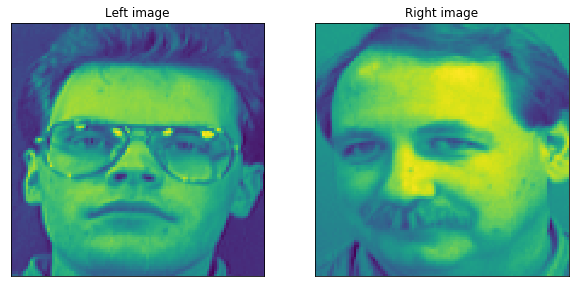

In [126]:
def plot_imgs(images = [], titles = [], figsize = (10,10)):
  size = len(images)
  fig = plt.figure(figsize=figsize)
  i = 1
  for image in images:
    ax = fig.add_subplot(1,size,i)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(titles[i-1])
    ax.imshow(image)
    i += 1
  return None

n_batch = 8

print("Label: ", batch_example[2][n_batch])
plot_imgs([batch_example[0][n_batch].reshape(105, 105), 
          batch_example[1][n_batch].reshape(105, 105)], ["Left image", "Right image"])


## Build model

In [0]:
class siameseCNN(nn.Module):
  def __init__(self):
    super().__init__() 
    
    self.CNN = nn.Sequential(nn.Conv2d(1, 64, 10),  
                             nn.ReLU(inplace=True),
                             nn.MaxPool2d(2,2), 
                             
                             nn.Conv2d(64, 128, 7),
                             nn.ReLU(inplace=True),
                             nn.MaxPool2d(2,2), 
                             
                             nn.Conv2d(128, 128, 4),
                             nn.ReLU(inplace=True),
                             nn.MaxPool2d(2,2), 
                             
                             nn.Conv2d(128, 256, 4),
                             nn.ReLU(inplace=True))
    
    self.FC =  nn.Sequential(nn.Linear(6*6*256, 128),
                             nn.Sigmoid(),
                             
                             nn.Linear(128, 1)) 
                            
  
  def forward_img(self, x):
    x = self.CNN(x)
    x = x.view(x.size()[0], -1)
    x = self.FC(x)
    
    return x
    
  def forward(self, x1, x2):
    featvect1 = self.forward_img(x1)
    featvect2 = self.forward_img(x2)
    return featvect1, featvect2

## Define loss 

In [0]:
def constrastiveLoss(x1, x2, label):
  euclidean_distance = F.pairwise_distance(x1, x2)
  loss = torch.mean((1-label) * torch.pow(euclidean_distance, 2) + 
                      (label) * torch.pow(torch.clamp(2.- euclidean_distance, min=0), 2))
  return loss

## Train network

In [180]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Training in", device)

model = siameseCNN()
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-5)

Training in cuda:0


In [181]:
epochs = 55
print_every = 10

counter = []
history = []
iteration = 0
best = 0

for epoch in range(epochs):
  for i, batch in enumerate(trainloader, 0):
    x1, x2, label = batch
    x1, x2, label = x1.to(device), x2.to(device), label.to(device)
    optimizer.zero_grad()
    
    out1, out2 = model.forward(x1, x2)
    loss = constrastiveLoss(out1, out2, label)
    loss.backward()
    optimizer.step()
    if i % print_every == 0:
      print("Epoch: {} loss: {}".format(epoch+1, loss.item()))
      iteration += print_every
      counter.append(iteration)
      history.append(loss.item())
      if best < loss.item():
        torch.save(model.state_dict(), "./siamese-pytorch.pth")
        best = loss.item()

Epoch: 1 loss: 1.8741822242736816
Epoch: 1 loss: 1.7466685771942139
Epoch: 2 loss: 1.622222661972046
Epoch: 2 loss: 2.11773419380188
Epoch: 3 loss: 2.1154356002807617
Epoch: 3 loss: 1.7325141429901123
Epoch: 4 loss: 1.481534481048584
Epoch: 4 loss: 2.202728748321533
Epoch: 5 loss: 1.9305708408355713
Epoch: 5 loss: 1.8290053606033325
Epoch: 6 loss: 1.9744677543640137
Epoch: 6 loss: 1.464426040649414
Epoch: 7 loss: 1.7787457704544067
Epoch: 7 loss: 1.598068118095398
Epoch: 8 loss: 1.6526868343353271
Epoch: 8 loss: 2.241611957550049
Epoch: 9 loss: 1.0851812362670898
Epoch: 9 loss: 1.9378424882888794
Epoch: 10 loss: 1.454573154449463
Epoch: 10 loss: 1.8131468296051025
Epoch: 11 loss: 1.9364237785339355
Epoch: 11 loss: 1.4173065423965454
Epoch: 12 loss: 1.0049057006835938
Epoch: 12 loss: 1.2622613906860352
Epoch: 13 loss: 1.3387292623519897
Epoch: 13 loss: 1.6488940715789795
Epoch: 14 loss: 1.4446468353271484
Epoch: 14 loss: 1.290543794631958
Epoch: 15 loss: 1.5395368337631226
Epoch: 15 los

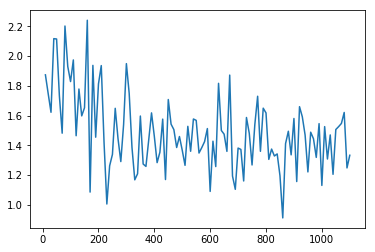

In [182]:
plt.plot(counter, history)
plt.show()

## Save and test model

In [0]:
torch.save(model.state_dict(), "face-recogn.pth")

In [183]:
model.eval()

# Same as above just changed the if 
def imgs_with_id(src):
  data = []
  imgs = 0
  for path, subdir, files in os.walk(src):
    for file in files:
      #if path[10:16] == "_S4_C2":
      if int(path[-2:]) > 37:
        if file[-3:] == "pgm":
          data.append((os.path.join(path, file), path[-2:]))
          imgs += 1
  return data, imgs 


def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show() 
    
testdata, total = imgs_with_id("data/")
print("Example: img ", testdata[0][0], " subject id ", testdata[0][1], " total imgs ", total)

Example: img  data/s38/8.pgm  subject id  38  total imgs  30


In [184]:
dataset = ChokePoint(testdata, transform=transforms.Compose([transforms.Resize((105, 105)),
                                                             transforms.ToTensor()]))
                     
testloader = torch.utils.data.DataLoader(dataset, shuffle=True, num_workers=8, batch_size=1)

it = iter(testloader)
#x1, _, _ = next(it)

acc = 0
total = 0
  
for i in range(len(testloader)):
  x1, x2, label = next(it)
  concatenated = torch.cat((x1, x2), 0)
                     
  out1, out2 = model(x1.to(device), x2.to(device))
  euc_dst = F.pairwise_distance(out1, out2)
  
  same = 0
  if euc_dst < 0.5:
    same = 1
    
  if same == int(label.numpy()):
    acc+=1
    
  total += 1
  #imshow(torchvision.utils.make_grid(concatenated), "Dissimilarity: {:2f}, Same: {}, Label: {}". format(euc_dst.item(), same, label))
  
  
print(acc, " ",total)
print("Accuracy: ", acc/total)

    
#imshow(torchvision.utils.make_grid(concatenated), "Dissimilarity: {:2f}, Same: {}, Label: {}". format(euc_dst.item(), same, label))


24   30
Accuracy:  0.8
